In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from mpl_toolkits import mplot3d
from PIL import Image, ImageDraw
from matplotlib.backends.backend_agg import FigureCanvasAgg
import numpy as np
import matplotlib
matplotlib.use('Agg')

In [375]:
class ACO:
    def __init__(self, num_pop, graph):
        n = len(graph)

        self.graph = graph

        self.population = [[0]] * num_pop # Each ant starts at city number 0
        self.dist = np.zeros(shape=(num_pop)) # dist[ant] = distance made so far

        self.pheromone = np.ones((n, n)) # Ones, so that alpha > 1 will increase probability 

        self.adjacency_matrix = np.zeros(shape=(n, n), dtype=np.float32) # [i, j] = Euclidean distance between city i and j

        # Setting up the distances
        for i in range(n):
            self.adjacency_matrix[i] = np.apply_along_axis(np.linalg.norm, 1, graph[i] - graph)

        # Banning paths from city to itself 
        self.adjacency_matrix = np.where(self.adjacency_matrix == 0, np.inf, self.adjacency_matrix)
        
    
    def main_loop(self, num_iter, alpha, beta, Q, rho):
        n = self.adjacency_matrix.shape[0]
        best_route = None
        min_dist = np.inf
        
        mu = 1 / self.adjacency_matrix
        ants = np.array(range(len(self.population)))

        for i in range(num_iter):
            self.population = [[0]] * len(self.population) # Each ant starts at city number 0
            self.dist = np.zeros(self.dist.shape)
            delta_tau = np.zeros_like(self.pheromone) # To perform pheromon decay after loop ends
            
            self.fast_ant(self, ants, alpha=alpha, mu=mu, beta=beta, n=n, Q=Q, delta_tau=delta_tau)

            min_ant = np.argmin(self.dist[self.dist != 0])

            if min_dist > self.dist[min_ant] and self.dist[min_ant] != 0:
                min_dist = np.copy(self.dist[min_ant])
                best_route = np.copy(self.population[min_ant])

            print("Iteration: %i\nMin distance: %.3f\nMin route %s" % (i + 1, min_dist, best_route)) 

            # Pheromone decay
            self.pheromone = (1 - rho) * self.pheromone + delta_tau
        
        return min_dist, best_route
    

    @np.vectorize(excluded=['self','alpha', 'mu', 'beta', 'n', 'Q', 'delta_tau'])
    def fast_ant(self, ant, alpha, mu, beta, n, Q, delta_tau):
        while len(self.population[ant]) != n:
            # Getting the last city that ant have visited so far
            current_city = self.population[ant][-1]
            # Temporary variable to compute probabilities later
            tmp = (self.pheromone[current_city] ** alpha) * (mu[current_city] ** beta)

            # Setting visited cities probabilities to zero
            for j in range(n):
                if j in self.population[ant]:
                    tmp[j] = 0

            # Probabilities itself
            prob = tmp / tmp.sum()

            # Cumulative probabilites to choose next city
            cum_prob = np.cumsum(prob)

            # Choosing next city while it hasn't been visited
            next_city = np.searchsorted(cum_prob, np.random.rand())

            while next_city in self.population[ant]:
                next_city = np.searchsorted(cum_prob, np.random.rand())

            self.population[ant].append(next_city)
            self.dist[ant] += self.adjacency_matrix[current_city][next_city]

            # Updating pheromon
            self.pheromone[next_city][current_city] += Q / self.dist[ant]
            self.pheromone[current_city][next_city] += Q / self.dist[ant]

            delta_tau[next_city][next_city] += Q / self.dist[ant]
            delta_tau[current_city][next_city] += Q / self.dist[ant]

            if len(self.population[ant]) == n:
                # Connecting the last city with the first
                self.dist[ant] += self.adjacency_matrix[0][self.population[ant][-1]]
    

    def main_loop_plot(self, num_iter, alpha, beta, Q, rho, gif_name="ACO"):
        n = self.adjacency_matrix.shape[0]
        best_route = None
        min_dist = np.inf
        ants = np.array(range(len(self.population)))
        
        mu = 1 / self.adjacency_matrix

        # plotting
        fig, ax = plt.subplots()
        images = []
        canvas = FigureCanvasAgg(fig)

        for i in range(num_iter):
            self.population = [[0]] * len(self.population) # Each ant starts at city number 0
            self.dist = np.zeros(self.dist.shape)
            delta_tau = np.zeros_like(self.pheromone) # To perform pheromon decay after loop ends
            
            self.fast_ant(self, ants, alpha=alpha, mu=mu, beta=beta, n=n, Q=Q, delta_tau=delta_tau)

            min_ant = np.argmin(self.dist[self.dist != 0])

            if min_dist > self.dist[min_ant] and self.dist[min_ant] != 0:
                min_dist = np.copy(self.dist[min_ant])
                best_route = np.copy(self.population[min_ant])

                arr_to_plot = self.graph[best_route]

                ax.plot(arr_to_plot[:, 0], arr_to_plot[:, 1], label="dist %.3f" % min_dist)
                ax.scatter(self.graph[:, 0], self.graph[:, 1], color="red")
                plt.legend(loc="best")

                # Render the plot as an RGBA buffer
                canvas.draw()
                buf = canvas.buffer_rgba()

                # Create a PIL Image from the RGBA buffer
                image = Image.frombytes('RGBA', canvas.get_width_height(), buf, 'raw', 'RGBA')
                images.append(image)
                plt.cla()

            print("Iteration: %i\nMin distance: %.3f\nMin route %s" % (i + 1, min_dist, best_route)) 

            # Pheromone decay
            self.pheromone = (1 - rho) * self.pheromone + delta_tau

        # something like pause    
        images.extend([images[-1]] * 100)

        images[0].save(f'{gif_name}.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=10, loop=0)
        return min_dist, best_route

In [376]:
def create_circle(n, radius=1):
    circle = []
    theta = 0
    delta = 2 * np.pi / n

    side_length = 2 * radius * np.sin(delta / 2)

    for _ in range(n):
        x = np.cos(theta)
        y = np.sin(theta)
        circle.append(np.array([x, y]))
        theta += delta


    return np.array(circle), n * side_length

In [377]:
file_path = r'D:\Opera_Download\xqf131.tsp'
def read_tsp_file(filepath):
    tsp = []
    with open(filepath) as file:
        for _ in range(8):
            file.readline()
        
        for line in file.readlines()[:-1]:
            _, x, y = line.split()
            tsp.append(np.array([np.float32(x), np.float32(y)]))

    return np.array(tsp)

In [378]:
"""
Min distance: 6.868
Min route [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 17 19]
Real ans 6.257

Min route [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Min dist: 6.272
 Real min dist: 6.272

 (num_iter=2_000, alpha=1, beta=0.5, rho=0, Q=6)
"""
# tsp1 = read_tsp_file(file_path) # Q = 564
graph, perim = create_circle(20)
test = ACO(200, graph)
dist, route = test.main_loop_plot(num_iter=100, alpha=1, beta=0.5, rho=1e-2, Q=6, gif_name="test")
print("Min dist: %.3f\n Real min dist: %.3f" % (dist, perim))

Iteration: 1
Min distance: 21.261
Min route [ 0 19 17  9  3 13 11  8  5  6  7  4 16 10 12 15  2  1 18 14]
Iteration: 2
Min distance: 21.261
Min route [ 0 19 17  9  3 13 11  8  5  6  7  4 16 10 12 15  2  1 18 14]
Iteration: 3
Min distance: 20.251
Min route [ 0 19 17 16 15 10  8  4  7 13 12 11  1 14  9  2  3 18  6  5]
Iteration: 4
Min distance: 18.074
Min route [ 0 19 18 14  9  6  8  7  4  3 12 11  5  1 17 16 15 10 13  2]
Iteration: 5
Min distance: 16.481
Min route [ 0 19 17 16  4  9 10  5  6  8  7 13 12 11  3  2 18 15 14  1]
Iteration: 6
Min distance: 16.481
Min route [ 0 19 17 16  4  9 10  5  6  8  7 13 12 11  3  2 18 15 14  1]
Iteration: 7
Min distance: 16.481
Min route [ 0 19 17 16  4  9 10  5  6  8  7 13 12 11  3  2 18 15 14  1]
Iteration: 8
Min distance: 16.481
Min route [ 0 19 17 16  4  9 10  5  6  8  7 13 12 11  3  2 18 15 14  1]
Iteration: 9
Min distance: 16.481
Min route [ 0 19 17 16  4  9 10  5  6  8  7 13 12 11  3  2 18 15 14  1]
Iteration: 10
Min distance: 16.481
Min route [

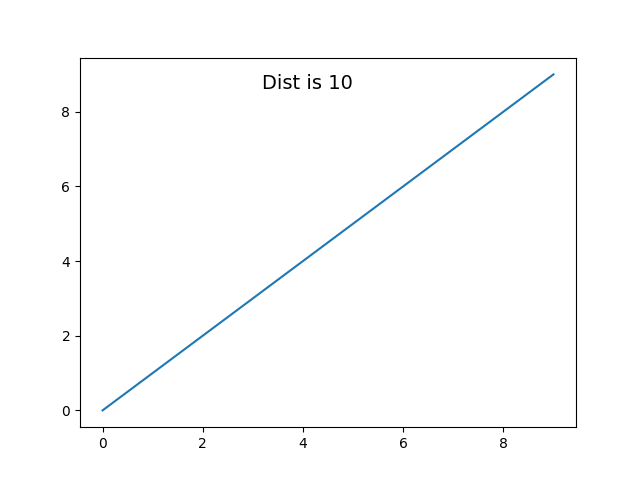

In [339]:
fig, ax = plt.subplots()
canvas = FigureCanvasAgg(fig)

ax.plot(range(10), range(10))
ax.text(5, 9, "Dist is 10", fontsize=14, ha="right", va="top")

canvas.draw()
buf = canvas.buffer_rgba()

# Create a PIL Image from the RGBA buffer
image = Image.frombytes('RGBA', canvas.get_width_height(), buf, 'raw', 'RGBA')
image